In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import string

from collections import defaultdict
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl
# from yellowbrick.classifier import ConfusionMatrix

/home/neo/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.probability import FreqDist
from nltk.util import ngrams
from collections import Counter
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def read_and_init(train_data_root_path):
            #Train, Dev, Test
            # Step 4: Split the data
            # Check if the current item is a file
            data_tr = []
            data_d = []
            data_te = []
            data_dix_train = {}
            data_dix_test = {}
            data_dix_dev = {}
            # data_train_dev_test = {}
            for item in os.listdir(train_data_root_path):
                    # Construct the full path to the current item
                    item_path = os.path.join(train_data_root_path , item)
                    # Check if the current item is a directory
                    if os.path.isdir(item_path):
                        print("-------------------------------------------------------------")
                        print("Collecting data For language: ", item_path.split("/")[-1])

                        # Loop through the contents of the subfolder
                        for sub_item in os.listdir(item_path):
                            # Construct the full path to the sub-item
                            sub_item_path = os.path.join(item_path, sub_item)

                            # Check if the sub-item is a file or directory
                            if os.path.isdir(sub_item_path):
                                language = item_path.split("/")[-1]
                                files_manager = {}
                                for file_name in os.listdir(sub_item_path):
                                        file_path = os.path.join(sub_item_path, file_name)
                                        #print(file_path)
                                        if 'train' in file_name:
                                                files_manager['train_file'] = file_path
                                                data_tr.append(pd.read_csv(files_manager['train_file']))
                                                data_dix_train[language] = list(pd.read_csv(files_manager['train_file'])['sentence'])
                                        elif 'dev' in file_name:
                                                files_manager['dev_file'] = file_path
                                                data_d.append(pd.read_csv(files_manager['dev_file']))
                                        elif 'test' in file_name:
                                                files_manager['test_file'] = file_path  
                                                data_te.append(pd.read_csv(files_manager['test_file']))
                                                data_dix_test[language] = list(pd.read_csv(files_manager['test_file'])['sentence'])
                                        else:
                                                print("This file is unknow") 
                            else:
                                # its a file
                                files_manager = {}
                                if 'train' in sub_item_path:
                                        files_manager['train_file'] = sub_item_path
                                        data_tr.append(pd.read_csv(files_manager['train_file']))
                                        data_dix_train[item_path.split("/")[-1]] = list(pd.read_csv(files_manager['train_file'])['sentence'])
                                elif 'dev' in sub_item_path:
                                        files_manager['dev_file'] = sub_item_path
                                        data_d.append(pd.read_csv(files_manager['dev_file']))
                                        data_dix_dev[item_path.split("/")[-1]] = list(pd.read_csv(files_manager['dev_file'])['sentence'])

                                elif 'test' in sub_item_path:
                                            files_manager['test_file'] = sub_item_path  
                                            data_te.append(pd.read_csv(files_manager['test_file']))
                                            data_dix_test[item_path.split("/")[-1]] = list(pd.read_csv(files_manager['test_file'])['sentence'])
                                else:
                                    print("This file is unknow")
            df_train  =    pd.concat(data_tr, ignore_index = True, sort=False)
            return  data_dix_train, data_dix_dev ,data_dix_test 

In [4]:
root_path = "/home/neo/thapelo/LID_Bert/Csv_Train_test_split/"
train, dev, test = read_and_init(root_path)

-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------


In [66]:
train['eng']

['SA overcoming HIV and Aids\n',
 'Vukuzenzele Unnamed\n',
 'As we continue our efforts to manage the devastating Coronavirus pandemic, we cannot ignore the other public health challenges that our country faces.\n',
 'For more than three dec ades, our country has been engaged in an ongoing struggle against HIV and AIDS, which has cost many lives and caused great hardship and suffering.\n',
 'Since the outbreak of COV ID-19 in the country, with the nation-wide lockdown and the pressure on our health facilities, many HIV , AIDS and tuberculosis services have suffered.\n',
 'This has posed a challenge for people testing and starting antiretroviral treatment.\n',
 'Many people found it difficult to collect their medicines and fewer people accessed other services, such as voluntary male medical circumcision.\n',
 'At the same time, there are many lessons that have been learnt from our public health response to the coronavirus pandemic that can strengthen our fight against HIV and TB.\n',
 '

In [8]:
def show_statistics(data):
    for language, sentences in data.items():
        
        word_list = ' '.join(sentences).split()
        
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = ''.join(sentences[0].split(' ')[:7])
    
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [5]:
def clean_text( text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers (retain only alphabets and spaces)
    # text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [6]:
data_preprocessed = {k: [clean_text(sentence) for sentence in v] for k, v in train.items()}

In [70]:
print('ORIGINAL STATISTICS TRAIN')
show_statistics(train)

ORIGINAL STATISTICS TRAIN
Language: tsn
-----------------------
Number of sentences	:	 3395
Number of words		:	 126938
Number of unique words	:	 14452
Sample extract		:	 Tšhonoenngweyagokonosetsadithuto...

Language: nso
-----------------------
Number of sentences	:	 3395
Number of words		:	 106331
Number of unique words	:	 13529
Sample extract		:	 AfrikaBorwaefenyaHIVleAIDS
...

Language: tso
-----------------------
Number of sentences	:	 3395
Number of words		:	 95695
Number of unique words	:	 14178
Sample extract		:	 Nkarhiwun'wanawakukumamatirikiya...

Language: zul
-----------------------
Number of sentences	:	 3395
Number of words		:	 60285
Number of unique words	:	 27402
Sample extract		:	 INingizimuAfrikainqobaIsandulelaNgculazi(i-HIV)kanye...

Language: eng
-----------------------
Number of sentences	:	 3395
Number of words		:	 83969
Number of unique words	:	 15169
Sample extract		:	 SAovercomingHIVandAids
...

Language: xho
-----------------------
Number of sentences	:	 3395


In [71]:
print('ORIGINAL STATISTICS DEV')
show_statistics(dev)

ORIGINAL STATISTICS DEV
Language: tsn
-----------------------
Number of sentences	:	 729
Number of words		:	 23126
Number of unique words	:	 4514
Sample extract		:	 Felasenosewetsamatshwafogo...

Language: nso
-----------------------
Number of sentences	:	 885
Number of words		:	 24033
Number of unique words	:	 4887
Sample extract		:	 Mengwagengyemeraroyeefetilego,re...

Language: tso
-----------------------
Number of sentences	:	 1071
Number of words		:	 29027
Number of unique words	:	 5917
Sample extract		:	 Xikongomeloxaswigevengaleswihlaselakavalumandleve...

Language: zul
-----------------------
Number of sentences	:	 981
Number of words		:	 16028
Number of unique words	:	 9276
Sample extract		:	 Kusezandlenizethunjengabazalikanyenogogono-mkhuluukuphatha...

Language: eng
-----------------------
Number of sentences	:	 1430
Number of words		:	 35714
Number of unique words	:	 7604
Sample extract		:	 Shehadtohavebrainsurgeryto...

Language: xho
-----------------------
Number of sente

In [72]:
print('ORIGINAL STATISTICS TEST')
show_statistics(test)

ORIGINAL STATISTICS TEST
Language: tsn
-----------------------
Number of sentences	:	 727
Number of words		:	 25166
Number of unique words	:	 4957
Sample extract		:	 Farebuapuophaa,redirisa...

Language: nso
-----------------------
Number of sentences	:	 727
Number of words		:	 20996
Number of unique words	:	 4442
Sample extract		:	 “Retlakgonagotšwelapeleka...

Language: tso
-----------------------
Number of sentences	:	 727
Number of words		:	 18256
Number of unique words	:	 4094
Sample extract		:	 Vatlurivamilawuavakhomiwini...

Language: zul
-----------------------
Number of sentences	:	 727
Number of words		:	 12265
Number of unique words	:	 7437
Sample extract		:	 Abazikancanengalokhoabafunaukukufundakodwaabangenasiqiniseko...

Language: eng
-----------------------
Number of sentences	:	 727
Number of words		:	 17497
Number of unique words	:	 4903
Sample extract		:	 Thisisanormaltenetofa...

Language: xho
-----------------------
Number of sentences	:	 727
Number of words		:	 1195

In [9]:
print('PREPROCESSED STATISTICS :')
show_statistics(data_preprocessed)

PREPROCESSED STATISTICS :
Language: tsn
-----------------------
Number of sentences	:	 3395
Number of words		:	 125410
Number of unique words	:	 9639
Sample extract		:	 tšhonoenngweyagokonosetsadithuto...

Language: nso
-----------------------
Number of sentences	:	 3395
Number of words		:	 104898
Number of unique words	:	 8740
Sample extract		:	 afrikaborwaefenyahivleaids...

Language: tso
-----------------------
Number of sentences	:	 3395
Number of words		:	 94333
Number of unique words	:	 9364
Sample extract		:	 nkarhiwunwanawakukumamatirikiya...

Language: zul
-----------------------
Number of sentences	:	 3395
Number of words		:	 59531
Number of unique words	:	 21537
Sample extract		:	 iningizimuafrikainqobaisandulelangculaziihivkanye...

Language: eng
-----------------------
Number of sentences	:	 3395
Number of words		:	 82571
Number of unique words	:	 9352
Sample extract		:	 saovercominghivandaids...

Language: xho
-----------------------
Number of sentences	:	 3395
Number of 

# The Naive Bayes Model

Bayes' Theorem

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence my name is Sudarshan into one of sk, cs, or en, the following are the probabilities we want to determine.

# Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

Vectorizing Training Data

|Sentence || my | is | I | love | name | it | Sudarshan | |----------------- ||:------: |:--: |:-: |:----: |:----: |:--------: |:---: | | my name is Sudarshan || 1 | 1 | 0 | 0 | 1 | 0 | 1 | | I love it || 0 | 0 | 1 | 1 | 0 | 1 | 0 |


In [10]:
sentences_train, y_train =[], []
for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [11]:
vectorizer = CountVectorizer()

In [12]:
x_train = vectorizer.fit_transform(sentences_train)
x_train

<37345x121700 sparse matrix of type '<class 'numpy.int64'>'
	with 738111 stored elements in Compressed Sparse Row format>

In [13]:
example_index = 0  # Change this index to view other examples
example = x_train[example_index].toarray()
example

array([[0, 0, 0, ..., 0, 0, 0]])

In [14]:
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train,y_train) #alpha is smoothening constant, takes into account unseen literals like name - 'Sudarshan'

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
data_val_preprocessed = {k: [clean_text(sentence) for sentence in v] for k,v in dev.items()}

In [16]:
sentences_val, y_val = [], []
for k,v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [17]:
x_val = vectorizer.transform(sentences_val)

In [18]:
predictions = naive_bayes.predict(x_val)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_val, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

Text(0.5, 19.049999999999997, 'Predicted Label')

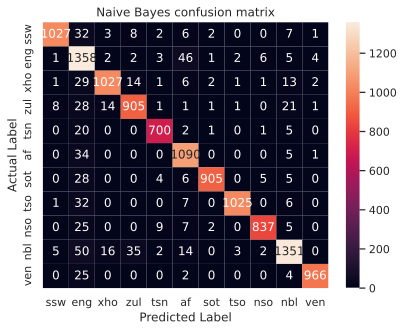

In [83]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
# plt.savefig(fname)

In [84]:
accuracy = accuracy_score(y_val, predictions)
f1_sco = f1_score(y_val, predictions, average = "weighted")
precision = precision_score(y_val, predictions,average = "weighted")
recall = recall_score(y_val, predictions, average = "weighted")

In [85]:
print('Accuracy : ' + str(accuracy))
print('F1 score : ' + str(f1_sco))
print('Precision: ' + str(precision))
print('Recall   : ' + str(recall))

Accuracy : 0.9452656474364389
F1 score : 0.9460790819170305
Precision: 0.9486063577235857
Recall   : 0.9452656474364389


In [86]:
f1_score(y_val, predictions, average='weighted')

0.9460790819170305

# Test data

In [19]:
data_test_preprocessed = {k: [clean_text(sentence) for sentence in v] for k,v in test.items()}

In [20]:
sentences_test, y_test = [], []
for k,v in data_test_preprocessed.items():
    for sentence in v:
        sentences_test.append(sentence)
        y_test.append(k)

In [21]:
x_test = vectorizer.transform(sentences_test)

In [22]:
predictions = naive_bayes.predict(x_test)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_test, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

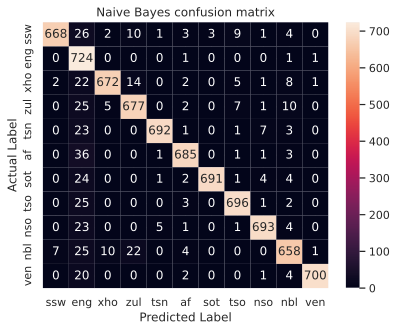

In [92]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("word_level_naive_bayes.pdf", dpi=300)
plt.savefig("word_level_naive_bayes.jpeg", dpi=300)

In [93]:
accuracy = accuracy_score(y_test, predictions)
f1_sco = f1_score(y_test, predictions, average = "weighted")
precision = precision_score(y_test, predictions,average = "weighted")
recall = recall_score(y_test, predictions, average = "weighted")

In [94]:
print('Accuracy : ' + str(accuracy))
print('F1 score : ' + str(f1_sco))
print('Precision: ' + str(precision))
print('Recall   : ' + str(recall))

Accuracy : 0.9448543203701388
F1 score : 0.9464690864790812
Precision: 0.9520706177666473
Recall   : 0.9448543203701388


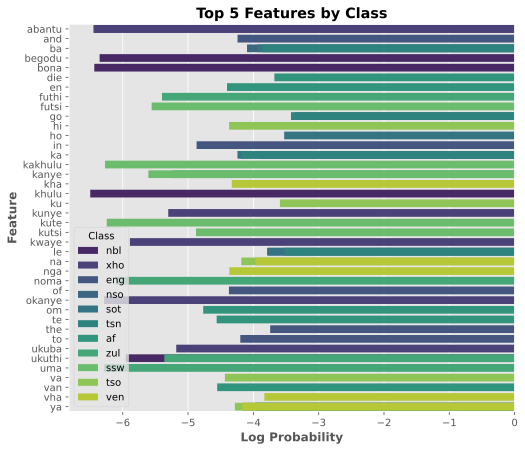

In [28]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of features
class_log_prob = naive_bayes.feature_log_prob_

# Number of top features to display
num_top_features = 5

# Create a DataFrame to store top features and their log probabilities
top_features_df = pd.DataFrame()

for i in range(len(naive_bayes.classes_)):
    top_features_indices = np.argsort(class_log_prob[i])[-num_top_features:]
    top_features = feature_names[top_features_indices]
    top_probabilities = class_log_prob[i][top_features_indices]
    
    class_df = pd.DataFrame({
        'Feature': top_features,
        'Log Probability': top_probabilities,
        'Class': [naive_bayes.classes_[i]] * num_top_features
    })
    
    top_features_df = pd.concat([top_features_df, class_df])

# Sort the DataFrame by Feature and Class to avoid overlap
top_features_df = top_features_df.sort_values(by=['Feature', 'Class'])

# Plotting
plt.figure(figsize=(8, 7))
sns.barplot(x='Log Probability', y='Feature', hue='Class', data=top_features_df, dodge=False, palette='viridis')
plt.title(f'Top {num_top_features} Features by Class', fontweight='bold')
plt.xlabel('Log Probability', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.legend(title='Class')
plt.show()

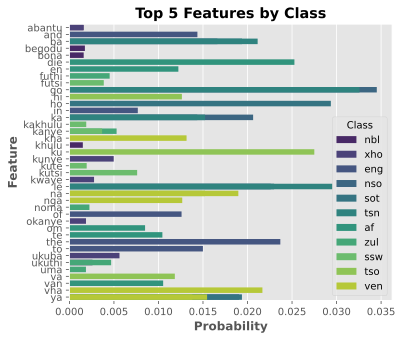

In [41]:
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of features
class_log_prob = naive_bayes.feature_log_prob_

# Convert log probabilities back to regular probabilities
class_prob = np.exp(class_log_prob)

# Number of top features to display
num_top_features = 5

# Create a DataFrame to store top features and their probabilities
top_features_df = pd.DataFrame()

for i in range(len(naive_bayes.classes_)):
    top_features_indices = np.argsort(class_prob[i])[-num_top_features:]
    top_features = feature_names[top_features_indices]
    top_probabilities = class_prob[i][top_features_indices]
    
    class_df = pd.DataFrame({
        'Feature': top_features,
        'Probability': top_probabilities,
        'Class': [naive_bayes.classes_[i]] * num_top_features
    })
    
    top_features_df = pd.concat([top_features_df, class_df])

# Sort the DataFrame by Feature and Class to avoid overlap
top_features_df = top_features_df.sort_values(by=['Feature', 'Class'])

# Plotting
plt.figure(figsize=(5.8, 5))
sns.barplot(x='Probability', y='Feature', hue='Class', data=top_features_df, dodge=False, palette='viridis')
plt.title(f'Top {num_top_features} Features by Class', fontweight='bold')
plt.xlabel('Probability', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.legend(title='Class')
plt.savefig('feature_importance_word_level.jpeg', dpi=300)
plt.savefig('feature_importance_word_level.pdf', dpi=300)
plt.show()

In [23]:
incorrectly_classified_sentences = []
correctly_classified_sentences   = []
for i, pred in enumerate(predictions):
          if pred == y_test[i]:
                  correctly_classified_sentences.append(sentences_test[i])
          else:
                  incorrectly_classified_sentences.append(sentences_test[i])
 


In [24]:
correct_lengths = [len(sent.split()) for sent in correctly_classified_sentences]
incorrect_lengths = [len(sent.split()) for sent in incorrectly_classified_sentences]

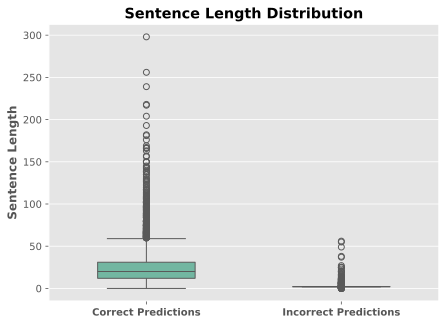

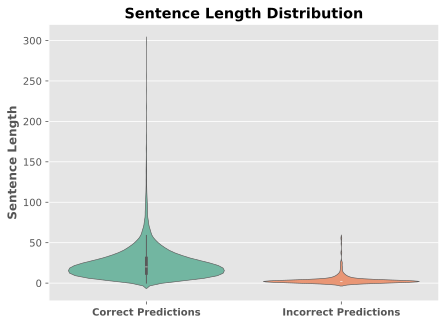

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [25]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=[correct_lengths, incorrect_lengths], palette="Set2", widths=0.5)
plt.xticks([0, 1], ['Correct Predictions', 'Incorrect Predictions'], fontweight='bold')
plt.title('Sentence Length Distribution', fontweight='bold')
plt.ylabel('Sentence Length', fontweight='bold')
plt.savefig('NBC_sentlen_box.pdf', dpi=300) 
plt.savefig('NBC_sentlen_box.jpeg', dpi=300) 
plt.show()
plt.close()

# Create a violin plot
plt.figure(figsize=(7, 5))
sns.violinplot(data=[correct_lengths, incorrect_lengths], palette="Set2")
plt.xticks([0, 1], ['Correct Predictions', 'Incorrect Predictions'], fontweight= 'bold')
plt.title('Sentence Length Distribution', fontweight='bold')
plt.ylabel('Sentence Length', fontweight='bold')
# plt.show()
plt.savefig('NBC_sentlen_violin.pdf', dpi=300) 
plt.show()
plt.savefig

# Simple Adjustments and Highlighting Model Shortcomings

In [95]:
naive_bayes = MultinomialNB(alpha= 0.0001, fit_prior = False) 
#alpha takes care for values which are not present in language dictionary.
# fit_prior is false to avoid prior probability otherwise prob will be biased towards 'sk' and 'eng'.Since cs has less sentences.
naive_bayes.fit(x_train,y_train)
predictions = naive_bayes.predict(x_val)
conf_mat = confusion_matrix(y_val,predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

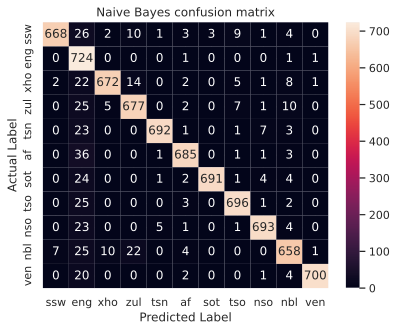

In [96]:
df_cm1 = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm1, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("word_level_naive_bayes_updated.pdf", dpi=300)
plt.savefig("word_level_naive_bayes_updated.jpeg", dpi=300)

In [35]:
f1_score(y_val, predictions, average='weighted')

0.9477802629195229

# Using Subwords to Shift Perspective

## Dummy Dataset

playing ; eating ; play ; reads ; tea

## Step 1

Break each word into characters

playing > p l a y i n g

## Step 2

Find common character sequences

ea, ing, play

## Step 3

### Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea
get_vocab Function :

* Takes in sentence_train as input and splits each sentence into words.
* Followed by splitting each word into letters and storing them in a dict with their frequency.

# get_stats Function :

* Takes in vocab dictionary as input.
* Split each word into letters and store it in symbols.
* Form a dictionary with keys as two frequent letters and values with their frequency.
* Return the pair frequency.



# 2 characters

In [97]:
# taken from https://arxiv.org/abs/1508.07909
import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [98]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
     
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab


In [99]:
vocab = get_vocab(sentences_train)
# vocab

In [100]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
#     print(pairs)
    best = max(pairs, key=pairs.get)
#     print(best)
    vocab = merge_vocab(best, vocab)

In [101]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >=2:
            merges[subword] += v

In [102]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [105]:
pkl.dump(merge_ordered, open('./merge_ordered.pkl', 'wb'))

In [108]:
def split_into_subwords(text):
    merges = pkl.load(open('./merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [109]:
split_into_subwords('Hello My name is Sudarshan')

'lo na me is an da'

In [110]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [111]:
show_statistics(data_preprocessed_subwords)

Language: tsn
-----------------------
Number of sentences	:	 3395
Number of words		:	 222847
Number of unique words	:	 73
Sample extract		:	 hotšnongweyago...

Language: nso
-----------------------
Number of sentences	:	 3395
Number of words		:	 181737
Number of unique words	:	 73
Sample extract		:	 kariwaboenyahi...

Language: tso
-----------------------
Number of sentences	:	 3395
Number of words		:	 175204
Number of unique words	:	 73
Sample extract		:	 kahiwanawakuku...

Language: zul
-----------------------
Number of sentences	:	 3395
Number of words		:	 173199
Number of unique words	:	 72
Sample extract		:	 nginzimukariba...

Language: eng
-----------------------
Number of sentences	:	 3395
Number of words		:	 116184
Number of unique words	:	 72
Sample extract		:	 sangmivehian...

Language: xho
-----------------------
Number of sentences	:	 3395
Number of words		:	 171416
Number of unique words	:	 72
Sample extract		:	 inyebahukuloma...

Language: ven
-----------------------
Numb

In [112]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [113]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [114]:
vectorizer = CountVectorizer()

In [115]:
x_train = vectorizer.fit_transform(data_train_subwords)
x_val = vectorizer.transform(data_val_subwords)

In [116]:
naive_bayes = MultinomialNB(alpha= 1.0, fit_prior = False)

In [117]:
naive_bayes.fit(x_train,y_train)
predictions = naive_bayes.predict(x_val)

In [118]:
confusion_matrix(y_val,predictions,labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

array([[ 916,   11,   30,   36,    6,    9,    8,   23,    0,   45,    4],
       [   5, 1225,    2,    2,    7,  133,   11,   17,    7,   15,    6],
       [  47,    6,  695,  176,    3,    9,    6,   11,    0,  135,    9],
       [  16,    6,  127,  580,    3,    5,    7,   11,    1,  216,    9],
       [   2,    2,    0,    0,  639,    9,   35,    1,   25,   15,    1],
       [   7,   37,    0,    2,    6, 1047,    6,    3,    0,   21,    1],
       [   6,    4,    2,    0,   33,   12,  862,    6,    4,   20,    4],
       [  14,    7,   10,   11,    1,   13,    8,  974,    0,   25,    8],
       [   3,    2,    1,    0,   39,   12,   20,    5,  785,   18,    0],
       [  21,   16,  137,  242,    4,   22,   11,   20,    0,  997,    8],
       [   1,   10,    7,    1,    1,    5,   12,   20,    0,   26,  914]])

In [119]:
f1_score(y_val ,predictions, average='weighted')

0.8145703447329564

In [ ]:
joblib.dump(naive_bayes, 'Data/Models/final_model.joblib')
joblib.dump(vectorizer, 'Data/Vectorizers/final_model.joblib')

# Evaluation of saved model

In [ ]:
model = joblib.load('Data/Models/final_model.joblib')
vectorizer = joblib.load('Data/Vectorizers/final_model.joblib')

In [ ]:
text = "czec a slovenština jsou velmi podobné jazyky." #czec and slovak are very similar languages.
text = text_process(text)
text = [split_into_subwords(text)]
text_vectorized = vectorizer.transform(text)

model.predict(text_vectorized)[0]

In [ ]:
text = "Ahoj, pekný deň!" #Hello, have great day!.
text = text_process(text)
text = [split_into_subwords(text)]
text_vectorized = vectorizer.transform(text)

model.predict(text_vectorized)[0]

In [ ]:
text = "Hello mate! Glad you reached till the end!" 
text = text_process(text)
text = [split_into_subwords(text)]
text_vectorized = vectorizer.transform(text)

model.predict(text_vectorized)[0]

# Bi-grams train vectors

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def preprocess_text( text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers (retain only alphabets and spaces)
    # text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [42]:
# Vectorize text data using character n-grams
def vectorize_text(train_texts, val_texts, test_texts, ngram_range):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, preprocessor=preprocess_text)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_val, X_test, vectorizer

In [43]:
# Vectorize the text data
# sentences_train, y_train
ngram_range  = (2,2)
X_train_vec,X_val_vec, X_test_vec, vectorizer = vectorize_text(sentences_train, sentences_val,sentences_test, ngram_range)

In [31]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec,y_train) 

MultinomialNB()

In [32]:
predictions = naive_bayes.predict(X_train_vec)
predictions

array(['tsn', 'af', 'tsn', ..., 'ssw', 'ssw', 'zul'], dtype='<U3')

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_train, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

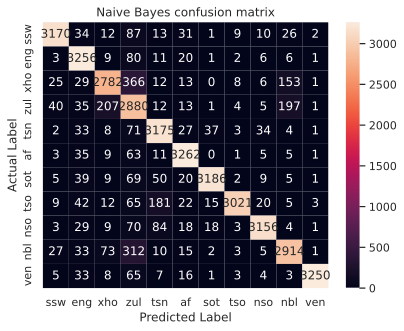

In [34]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [35]:
predictions = naive_bayes.predict(X_val_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_val, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

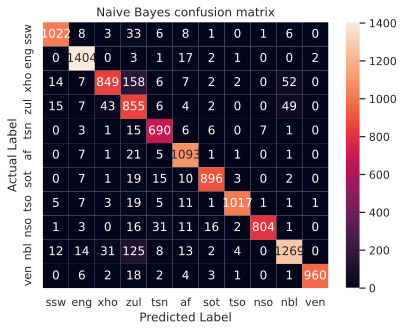

In [37]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [44]:
# Test
predictions = naive_bayes.predict(X_test_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_test, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

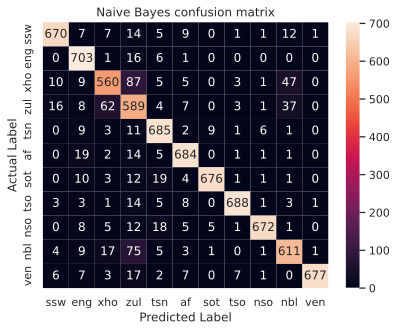

In [47]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-test-word_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-test-word_naive_bayes.jpeg", dpi=300)

In [48]:
accuracy = accuracy_score(y_test, predictions)
f1_sco = f1_score(y_test, predictions, average = "weighted")
precision = precision_score(y_test, predictions,average = "weighted")
recall = recall_score(y_test, predictions, average = "weighted")

In [49]:
print('Accuracy : ' + str(accuracy))
print('F1 score : ' + str(f1_sco))
print('Precision: ' + str(precision))
print('Recall   : ' + str(recall))

Accuracy : 0.9022133299987495
F1 score : 0.9035080852915062
Precision: 0.9069923146156057
Recall   : 0.9022133299987495


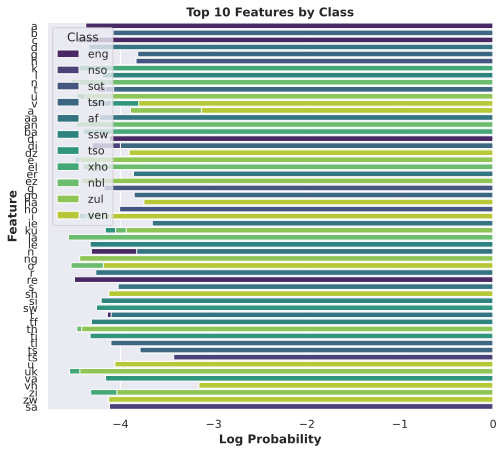

In [54]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of features
class_log_prob = naive_bayes.feature_log_prob_

# Number of top features to display
num_top_features = 10

# Create a DataFrame to store top features and their log probabilities
top_features_df = pd.DataFrame()

for i in range(len(naive_bayes.classes_)):
    top_features_indices = np.argsort(class_log_prob[i])[-num_top_features:]
    top_features = feature_names[top_features_indices]
    top_probabilities = class_log_prob[i][top_features_indices]
    
    class_df = pd.DataFrame({
        'Feature': top_features,
        'Log Probability': top_probabilities,
        'Class': [naive_bayes.classes_[i]] * num_top_features
    })
    
    top_features_df = pd.concat([top_features_df, class_df])

# Sort the DataFrame by Feature and Class to avoid overlap
top_features_df = top_features_df.sort_values(by=['Feature', 'Class'])

# Plotting
plt.figure(figsize=(8, 7))
sns.barplot(x='Log Probability', y='Feature', hue='Class', data=top_features_df, dodge=False, palette='viridis')
plt.title(f'Top {num_top_features} Features by Class', fontweight='bold')
plt.xlabel('Log Probability', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.legend(title='Class')
plt.show()

# Tri-grams

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def preprocess_text( text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers (retain only alphabets and spaces)
    # text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [56]:
# Vectorize text data using character n-grams
def vectorize_text(train_texts, val_texts, test_texts, ngram_range):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, preprocessor=preprocess_text)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_val, X_test, vectorizer

In [57]:
# Vectorize the text data
# sentences_train, y_train
ngram_range  = (3,3)
X_train_vec,X_val_vec, X_test_vec, vectorizer = vectorize_text(sentences_train, sentences_val,sentences_test, ngram_range)

In [58]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec,y_train) 

MultinomialNB()

In [59]:
predictions = naive_bayes.predict(X_train_vec)
predictions

array(['tsn', 'eng', 'tsn', ..., 'ssw', 'ssw', 'zul'], dtype='<U3')

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_train, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

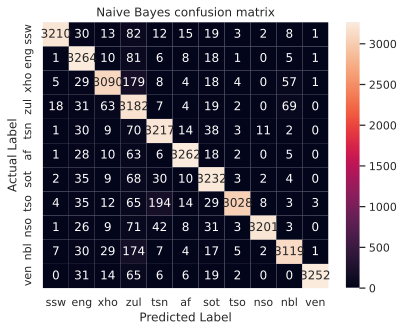

In [61]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [62]:
predictions = naive_bayes.predict(X_val_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_val, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

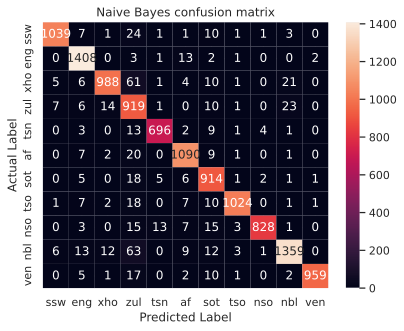

In [64]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [65]:
# Test
predictions = naive_bayes.predict(X_test_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_test, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

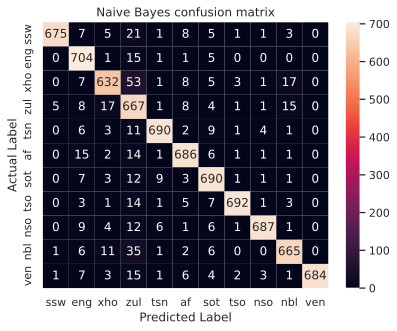

In [67]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-test-word_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-test-word_naive_bayes.jpeg", dpi=300)

In [68]:
accuracy = accuracy_score(y_test, predictions)
f1_sco = f1_score(y_test, predictions, average = "weighted")
precision = precision_score(y_test, predictions,average = "weighted")
recall = recall_score(y_test, predictions, average = "weighted")

In [69]:
print('Accuracy : ' + str(accuracy))
print('F1 score : ' + str(f1_sco))
print('Precision: ' + str(precision))
print('Recall   : ' + str(recall))

Accuracy : 0.9343503813930224
F1 score : 0.9353864541537626
Precision: 0.9385366854175431
Recall   : 0.9343503813930224


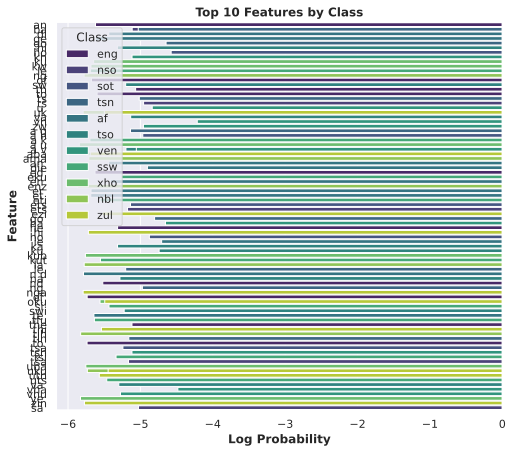

In [70]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of features
class_log_prob = naive_bayes.feature_log_prob_

# Number of top features to display
num_top_features = 10

# Create a DataFrame to store top features and their log probabilities
top_features_df = pd.DataFrame()

for i in range(len(naive_bayes.classes_)):
    top_features_indices = np.argsort(class_log_prob[i])[-num_top_features:]
    top_features = feature_names[top_features_indices]
    top_probabilities = class_log_prob[i][top_features_indices]
    
    class_df = pd.DataFrame({
        'Feature': top_features,
        'Log Probability': top_probabilities,
        'Class': [naive_bayes.classes_[i]] * num_top_features
    })
    
    top_features_df = pd.concat([top_features_df, class_df])

# Sort the DataFrame by Feature and Class to avoid overlap
top_features_df = top_features_df.sort_values(by=['Feature', 'Class'])

# Plotting
plt.figure(figsize=(8, 7))
sns.barplot(x='Log Probability', y='Feature', hue='Class', data=top_features_df, dodge=False, palette='viridis')
plt.title(f'Top {num_top_features} Features by Class', fontweight='bold')
plt.xlabel('Log Probability', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.legend(title='Class')
plt.show()

# Quad-gram

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def preprocess_text( text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers (retain only alphabets and spaces)
    # text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [105]:
# Vectorize text data using character n-grams
def vectorize_text(train_texts, val_texts, test_texts, ngram_range):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, preprocessor=preprocess_text)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_val, X_test, vectorizer

In [73]:
# Vectorize the text data
# sentences_train, y_train
ngram_range  = (4,4)
X_train_vec,X_val_vec, X_test_vec, vectorizer = vectorize_text(sentences_train, sentences_val,sentences_test, ngram_range)

In [74]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec,y_train) 

MultinomialNB()

In [75]:
predictions = naive_bayes.predict(X_train_vec)
predictions

array(['tsn', 'af', 'tsn', ..., 'ssw', 'ssw', 'zul'], dtype='<U3')

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_train, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

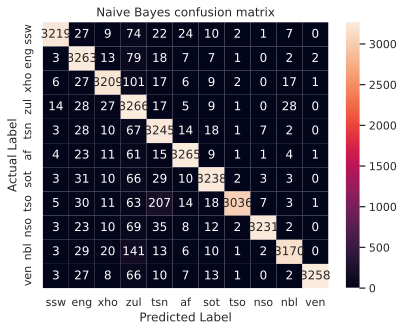

In [77]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [78]:
predictions = naive_bayes.predict(X_val_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_val, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

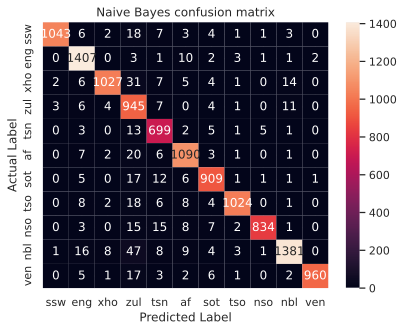

In [80]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [81]:
# Test
predictions = naive_bayes.predict(X_test_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_test, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

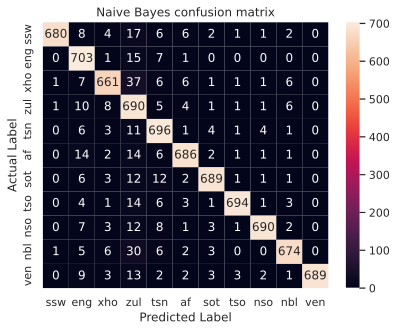

In [83]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-test-word_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-test-word_naive_bayes.jpeg", dpi=300)

In [84]:
accuracy = accuracy_score(y_test, predictions)
f1_sco = f1_score(y_test, predictions, average = "weighted")
precision = precision_score(y_test, predictions,average = "weighted")
recall = recall_score(y_test, predictions, average = "weighted")

In [85]:
print('Accuracy : ' + str(accuracy))
print('F1 score : ' + str(f1_sco))
print('Precision: ' + str(precision))
print('Recall   : ' + str(recall))

Accuracy : 0.9443541327998
F1 score : 0.9452675132327506
Precision: 0.9482619591539146
Recall   : 0.9443541327998


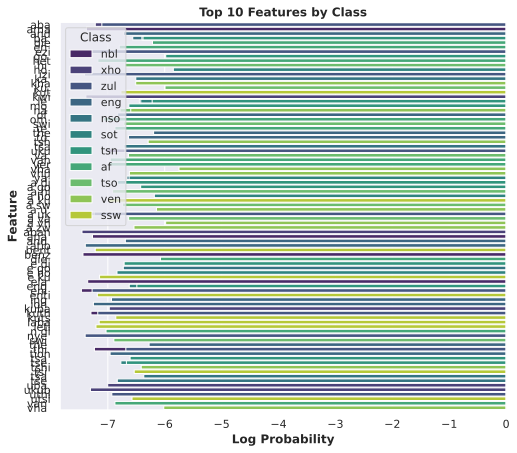

In [86]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of features
class_log_prob = naive_bayes.feature_log_prob_

# Number of top features to display
num_top_features = 10

# Create a DataFrame to store top features and their log probabilities
top_features_df = pd.DataFrame()

for i in range(len(naive_bayes.classes_)):
    top_features_indices = np.argsort(class_log_prob[i])[-num_top_features:]
    top_features = feature_names[top_features_indices]
    top_probabilities = class_log_prob[i][top_features_indices]
    
    class_df = pd.DataFrame({
        'Feature': top_features,
        'Log Probability': top_probabilities,
        'Class': [naive_bayes.classes_[i]] * num_top_features
    })
    
    top_features_df = pd.concat([top_features_df, class_df])

# Sort the DataFrame by Feature and Class to avoid overlap
top_features_df = top_features_df.sort_values(by=['Feature', 'Class'])

# Plotting
plt.figure(figsize=(8, 7))
sns.barplot(x='Log Probability', y='Feature', hue='Class', data=top_features_df, dodge=False, palette='viridis')
plt.title(f'Top {num_top_features} Features by Class', fontweight='bold')
plt.xlabel('Log Probability', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.legend(title='Class')
plt.show()

# N-gram combine

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def preprocess_text( text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers (retain only alphabets and spaces)
    # text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [60]:
# Vectorize text data using character n-grams
def vectorize_text(train_texts, val_texts, test_texts, ngram_range):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, preprocessor=preprocess_text)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_val, X_test, vectorizer

In [89]:
# Vectorize the text data
# sentences_train, y_train
ngram_range  = (2,4)
X_train_vec,X_val_vec, X_test_vec, vectorizer = vectorize_text(sentences_train, sentences_val,sentences_test, ngram_range)

In [90]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec,y_train) 

MultinomialNB()

In [91]:
predictions = naive_bayes.predict(X_train_vec)
predictions

array(['tsn', 'eng', 'tsn', ..., 'ssw', 'ssw', 'zul'], dtype='<U3')

In [92]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_train, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

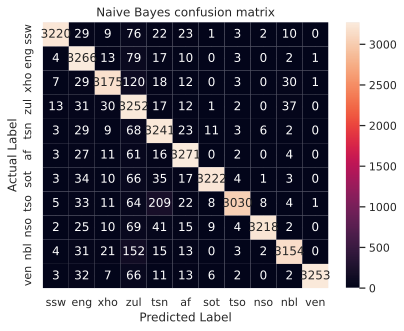

In [93]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [94]:
predictions = naive_bayes.predict(X_val_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_val, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

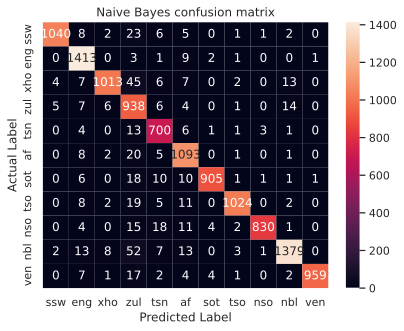

In [96]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-train-word_level_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-train-word_level_naive_bayes.jpeg", dpi=300)

In [97]:
# Test
predictions = naive_bayes.predict(X_test_vec)
predictions

array(['tsn', 'tsn', 'tsn', ..., 'ssw', 'ssw', 'ssw'], dtype='<U3')

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
c_matrxi = confusion_matrix(y_test, predictions, labels=['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])

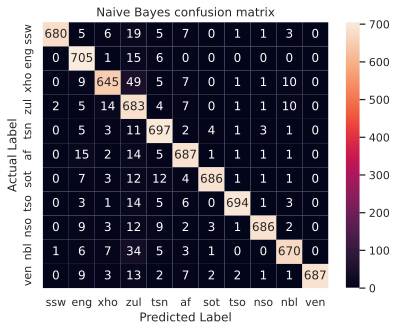

In [99]:
df_cm = pd.DataFrame(c_matrxi, index = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'],
          columns = ['ssw', 'eng', 'xho', 'zul', 'tsn', 'af', 'sot', 'tso', 'nso', 'nbl', 'ven'])
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, fmt='g')# font
# plt.title("Accuracy = " + str(accuracy),size = 18)
plt.title("Naive Bayes confusion matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.savefig("bigram-test-word_naive_bayes.pdf", dpi=300)
plt.savefig("bigram-test-word_naive_bayes.jpeg", dpi=300)

In [100]:
accuracy = accuracy_score(y_test, predictions)
f1_sco = f1_score(y_test, predictions, average = "weighted")
precision = precision_score(y_test, predictions,average = "weighted")
recall = recall_score(y_test, predictions, average = "weighted")

In [101]:
print('Accuracy : ' + str(accuracy))
print('F1 score : ' + str(f1_sco))
print('Precision: ' + str(precision))
print('Recall   : ' + str(recall))

Accuracy : 0.9403526322370889
F1 score : 0.9413903326798854
Precision: 0.9447386347751122
Recall   : 0.9403526322370889


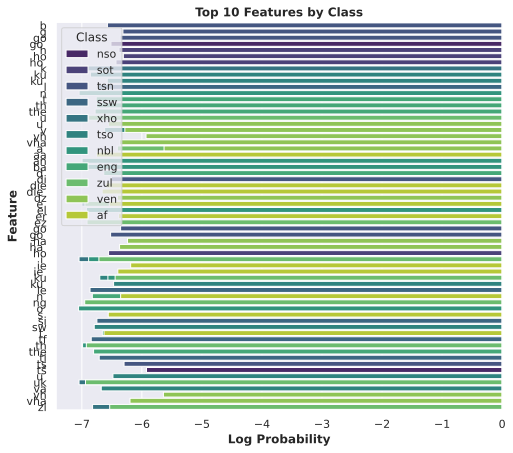

In [102]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the log probabilities of features
class_log_prob = naive_bayes.feature_log_prob_

# Number of top features to display
num_top_features = 10

# Create a DataFrame to store top features and their log probabilities
top_features_df = pd.DataFrame()

for i in range(len(naive_bayes.classes_)):
    top_features_indices = np.argsort(class_log_prob[i])[-num_top_features:]
    top_features = feature_names[top_features_indices]
    top_probabilities = class_log_prob[i][top_features_indices]
    
    class_df = pd.DataFrame({
        'Feature': top_features,
        'Log Probability': top_probabilities,
        'Class': [naive_bayes.classes_[i]] * num_top_features
    })
    
    top_features_df = pd.concat([top_features_df, class_df])

# Sort the DataFrame by Feature and Class to avoid overlap
top_features_df = top_features_df.sort_values(by=['Feature', 'Class'])

# Plotting
plt.figure(figsize=(8, 7))
sns.barplot(x='Log Probability', y='Feature', hue='Class', data=top_features_df, dodge=False, palette='viridis')
plt.title(f'Top {num_top_features} Features by Class', fontweight='bold')
plt.xlabel('Log Probability', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.legend(title='Class')
plt.show()

# Other Traditional Machine learning Models

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [59]:
def preprocess_text( text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers (retain only alphabets and spaces)
    # text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    return text

In [106]:
# Vectorize text data using character n-grams
# def vectorize_text(train_texts, test_texts, ngram_range):
#     vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, preprocessor=preprocess_text)
#     X_train = vectorizer.fit_transform(train_texts)
#     X_test = vectorizer.transform(test_texts)
#     return X_train, X_test, vectorizer

# Train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred)

# Main pipeline function
def main_pipeline(file_paths, ngram_range):
    # Load and concatenate data from all files
    # data = pd.concat([load_data(file_path) for file_path in file_paths])
    
    # Split data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)
    
    # Vectorize the text data
    X_train_vec, X_val, X_test_vec, vectorizer = vectorize_text(sentences_train, sentences_val,sentences_test, ngram_range)
    
    # Initialize models
    models = {
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        # 'Naive Bayes': MultinomialNB(),
        'SVM': SVC()
    }
    
    # Train and evaluate each model
    results = {}
    for model_name, model in models.items():
        results[model_name] = train_and_evaluate_model(model, X_train_vec, y_train, X_test_vec, y_test)
    
    # Print evaluation results
    for model_name, result in results.items():
        print(f"Results for {model_name} with n-grams {ngram_range}:\n{result}\n")

# File paths (update these paths to your dataset files)
file_paths = ['path_to_english_data.csv', 'path_to_spanish_data.csv', 'path_to_french_data.csv']

# Run pipeline for different n-grams
print("Training and evaluating with bigrams:")
main_pipeline(file_paths, ngram_range=(2, 2))

print("Training and evaluating with trigrams:")
main_pipeline(file_paths, ngram_range=(3, 3))

print("Training and evaluating with quadgrams:")
main_pipeline(file_paths, ngram_range=(4, 4))


Training and evaluating with bigrams:
Results for KNN with n-grams (2, 2):
              precision    recall  f1-score   support

          af       0.92      0.89      0.90       727
         eng       0.84      0.92      0.87       727
         nbl       0.81      0.65      0.72       727
         nso       0.93      0.91      0.92       727
         sot       0.93      0.91      0.92       727
         ssw       0.90      0.91      0.91       727
         tsn       0.83      0.93      0.88       727
         tso       0.92      0.94      0.93       727
         ven       0.83      0.93      0.87       727
         xho       0.82      0.63      0.71       727
         zul       0.64      0.74      0.69       727

    accuracy                           0.85      7997
   macro avg       0.85      0.85      0.85      7997
weighted avg       0.85      0.85      0.85      7997


Results for Logistic Regression with n-grams (2, 2):
              precision    recall  f1-score   support

   

In [61]:
# Train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred)

# Main pipeline function
def main_pipeline( ngram_range):
    # Load and concatenate data from all files
    # data = pd.concat([load_data(file_path) for file_path in file_paths])
    
    # Split data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)
    
    # Vectorize the text data
    X_train_vec, X_val, X_test_vec, vectorizer = vectorize_text(sentences_train, sentences_val,sentences_test, ngram_range)
    
    # Initialize models
    models = {
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        # 'Naive Bayes': MultinomialNB(),
        'SVM': SVC()
    }
    
    # Train and evaluate each model
    results = {}
    for model_name, model in models.items():
        results[model_name] = train_and_evaluate_model(model, X_train_vec, y_train, X_test_vec, y_test)
    
    # Print evaluation results
    for model_name, result in results.items():
        print(f"Results for {model_name} with n-grams {ngram_range}:\n{result}\n")
print("Training and evaluating with N-grams combined:")
main_pipeline( ngram_range=(2, 4))

Training and evaluating with N-grams combined:
Results for KNN with n-grams (2, 4):
              precision    recall  f1-score   support

          af       0.18      0.07      0.11       727
         eng       0.15      0.09      0.11       727
         nbl       0.11      0.05      0.07       727
         nso       0.34      0.42      0.38       727
         sot       0.21      0.31      0.25       727
         ssw       0.12      0.25      0.16       727
         tsn       0.26      0.55      0.35       727
         tso       0.21      0.28      0.24       727
         ven       0.47      0.33      0.39       727
         xho       0.16      0.04      0.06       727
         zul       0.16      0.04      0.06       727

    accuracy                           0.22      7997
   macro avg       0.21      0.22      0.20      7997
weighted avg       0.21      0.22      0.20      7997


Results for Logistic Regression with n-grams (2, 4):
              precision    recall  f1-score   sup